In [30]:
import awkward as ak 
import numpy as np
import matplotlib.pyplot as plt
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import hist.dask as hda
import uproot
from ak_tools import ak_equals
import pickle

In [2]:
events = NanoEventsFactory.from_root( 
    {"../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" 
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

In [46]:
def jet_truehiggs(reco_particles,mc_particles,true_higgs,reco_mc_index,jet_constits_index,condition='pR',pcrit=(50,5)):
    '''
    compares jet constituents to true higgs products 
    
    Parameters:
    ----------
    reco_particles :: array
        array with all the reco particles
    
    mc_particles :: array
        array with all the mc particles
    
    true_higgs :: array 
        array containing the mc indices of all the children of the higgs in each event 
    
    reco_mc_index :: array 
        array containing a list of mc indices for each reco index
    
    jet_constits_index :: array 
        indices of the pfos contained in the jets in the reco particle array
    
    condition :: str (optional)
        'pR' - the link with the closest momentum match is from the true higgs, to within 50% of the reco momentum 
               or 5 GeV, otherwise the closest \Delta R between the two closest momentum matches
               (criteria can be changed with pcrit)
        'p' - the link with the closest momentum match is from the true higgs
        'any' - any of one of the links from reco particles to mc particles is from the true higgs 
        'all' - all of the links from reco particles to mc particles is from the true higgs 
    
    pcrit :: tuple (optional)
        tuple defining the criteria for using momentum when condition = 'pR' as 
        (percent,absolute) FINISH DESCRIPTION
        
    Returns:
    -------
    
    '''
    matrix = False
    
    # throw error if any of the things are not the right lengths
    if not (len(reco_particles) == len(mc_particles) and len(mc_particles) == len(true_higgs) and len(true_higgs) == len(reco_mc_index) and len(reco_mc_index) == len(jet_constits_index)):
        raise ValueError('first 5 arrays must have the same number of events')
    
    jet_mcindices = reco_mc_index[jet_constits_index]
    jet_con_in_higgs = []
    
    if condition == 'pR':
        # complete (right now this is the same as 'p')
        matched_gen = ak.unflatten(mc_particles[ak.flatten(reco_mc_index,axis=2)],ak.flatten(ak.num(reco_mc_index,axis=2)),axis=1)
        
        mc_reco_cartesian = ak.argcartesian({'mc':matched_gen.p,'reco':ak.singletons(reco_particles.p,axis=1)},axis=2)
        mc_p_argmin = ak.singletons(ak.argmin(abs(matched_gen.p[mc_reco_cartesian['mc']] - ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']]),axis=2),axis=1)
        
        all_jet_inds = ak.flatten(reco_mc_index[mc_p_argmin],axis=2)[jet_constits_index]
        
        for n in range(len(all_jet_inds)):
            jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

        jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
    elif condition == 'any' or condition == 'all':
        all_jet_inds = ak.flatten(jet_mcindices,axis=2)
        
        jet_con_in_higgs = []

        for n in range(len(all_jet_inds)):
            jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

        jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
        if condition == 'any':
            jet_con_in_higgs = ak.any(ak.unflatten(jet_con_in_higgs,ak.flatten(ak.num(jet_mcindices,axis=2)),axis=1),axis=2)
        else:
            jet_con_in_higgs = ak.all(ak.unflatten(jet_con_in_higgs,ak.flatten(ak.num(jet_mcindices,axis=2)),axis=1),axis=2)
        
    elif condition == 'p':
        matched_gen = ak.unflatten(mc_particles[ak.flatten(reco_mc_index,axis=2)],ak.flatten(ak.num(reco_mc_index,axis=2)),axis=1)
        
        mc_reco_cartesian = ak.argcartesian({'mc':matched_gen.p,'reco':ak.singletons(reco_particles.p,axis=1)},axis=2)
        mc_p_argmin = ak.singletons(ak.argmin(abs(matched_gen.p[mc_reco_cartesian['mc']] - ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']]),axis=2),axis=1)
        
        all_jet_inds = ak.flatten(reco_mc_index[mc_p_argmin],axis=2)[jet_constits_index]
        
        if matrix:
            jet_con_in_higgs = ak_equals(all_jet_inds,true_higgs)
        else:
            for n in range(len(all_jet_inds)):
                jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

            jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
    else:
        raise ValueError('condition must be \'p\', \'any\', or \'all\'')
    
    
    return jet_con_in_higgs

## Trying this technique for inner-event slicing
events with a z boson decaying to mu mu with the two mus removed

In [3]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)

pfopair = dak.argcombinations(events.PandoraPFOs, 2, fields=["p1", "p2"])

all_muons_mask = (abs(events.PandoraPFOs[pfopair.p1].pdgId) == 13) & (abs(events.PandoraPFOs[pfopair.p2].pdgId) == 13)

invmass = (events.PandoraPFOs[pfopair.p1][all_muons_mask] + events.PandoraPFOs[pfopair.p2][all_muons_mask]).mass

inds = dak.singletons(dak.argmin(abs(invmass - 91.2), axis=1))


mu1ind = pfopair.p1[all_muons_mask][inds]
mu2ind = pfopair.p2[all_muons_mask][inds]

In [4]:
m1 = mu1ind[muonsevent].compute()
m2 = mu2ind[muonsevent].compute()

p = events.PandoraPFOs[muonsevent].compute()

In [10]:
# what is faster, binary or, or concat?

In [12]:
%%time
x = []
y = []
z = []
E = []

local_inds = ak.local_index(p)
total_mask = ((ak_equals(local_inds, m1)) | (ak_equals(local_inds, m2))) != True

for n in range(len(p)):
    x.append(np.array(p.x[n][total_mask[n]]))
    y.append(np.array(p.y[n][total_mask[n]]))
    z.append(np.array(p.z[n][total_mask[n]]))
    E.append(np.array(p.E[n][total_mask[n]]))

x = ak.Array(x)
y = ak.Array(y)
z = ak.Array(z)
E = ak.Array(E)

# time 56.3 s

CPU times: user 1min 31s, sys: 775 ms, total: 1min 31s
Wall time: 1min 35s


In [13]:
select_pfos = ak.zip(
    {
        'px': x,
        'py': y,
        'pz': z,
        'E': E,
    },
    with_name="LorentzVector",
)

In [14]:
select_clst = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)


jets = ak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

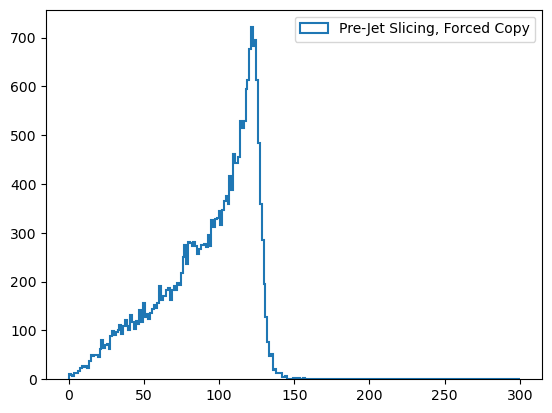

In [15]:
jetpair = ak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs

nbins = 250
mini = 0 
maxi = 300

plt.close(1);plt.figure(1)
plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=1.5,
         label='Pre-Jet Slicing, Forced Copy')


# hist_clusters_2 = (
#     hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Invariant Mass [GeV]") 
#     .Double()
#     .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
# )

# hist_clusters_2.compute().plot1d(label='Pre-Jet Slicing, Masking')
# dak.necessary_columns(hist_clusters_2)

plt.legend()

In [16]:
pfo_index = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=2)

In [11]:
# linked_gen = events.PandoraPFOs.matched_gen
# linked_pdg = linked_gen.pdgId[muonsevent].compute()[total_mask][ak.flatten(pfo_index,axis=2)]

## Comparing Jets to True Higgs

In [17]:
file = [uproot.open("../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004.Pe2e2h.eR.pL.n000.d_dstm_15090_0.slcio.edm4hep.root"),
        uproot.open("../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004.Pe2e2h.eR.pL.n000.d_dstm_15090_1.slcio.edm4hep.root"),
        uproot.open("../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004.Pe2e2h.eR.pL.n000.d_dstm_15090_2.slcio.edm4hep.root")]

evs = [file[n]['events'] for n in range(3)]

uproot_parinds_lst = [(evs[n][f'MCParticlesSkimmed#{0}/MCParticlesSkimmed#{0}.index']).array() for n in range(2,-1,-1)]
uproot_parinds = ak.concatenate(uproot_parinds_lst,axis=0)

uproot_daughinds_lst = [(evs[n][f'MCParticlesSkimmed#{1}/MCParticlesSkimmed#{1}.index']).array() for n in range(2,-1,-1)]
uproot_daughinds = ak.concatenate(uproot_daughinds_lst,axis=0)

uproot_mcstatus_lst = [(evs[n][f'MCParticlesSkimmed/MCParticlesSkimmed.generatorStatus']).array() for n in range(2,-1,-1)]
uproot_mcstatus = ak.concatenate(uproot_mcstatus_lst,axis=0)


In [18]:
def daughter_tree(event,start_ind):
    '''
    returns list of all daughters 
    '''
    curr_ind = ak.Array([-1])
    daugh_ind = ak.Array([start_ind])

    ind_lst = []

    flag = True

    while flag:
        curr_ind = daugh_ind

        daugh_ind = np.unique(ak.flatten(daugh_inds[event][curr_ind],axis=-1))

        ind_lst.append(list(curr_ind))

        if len(daugh_ind) == 0:
            flag = False 

    return ind_lst

In [19]:
pshape = (events.MCParticlesSkimmed.parents_end - events.MCParticlesSkimmed.parents_begin).compute()
par_inds = ak.unflatten(uproot_parinds,ak.flatten(pshape),axis=1)

dshape = (events.MCParticlesSkimmed.daughters_end - events.MCParticlesSkimmed.daughters_begin).compute()
daugh_inds = ak.unflatten(uproot_daughinds,ak.flatten(dshape),axis=1)

In [20]:
pdgids = events.MCParticlesSkimmed.pdgId.compute()

In [41]:
%%time
full_run = False

if full_run:
    higgs_daughter_tree = []

    for event in range(len(pdgids)):
        start_ind = ak.local_index(pdgids[event])[pdgids[event] == 25][0]

        higgs_daughter_tree.append(daughter_tree(event,start_ind))

        if event % 1000 == 0:
            print(event)

    higgs_daughter_tree_arr = ak.Array(higgs_daughter_tree)

    higgs_children = ak.flatten(higgs_daughter_tree_arr,axis=2)
else:
    higgs_children = pickle.load(open('higgs_children.pickle','rb'))
    higgs_daughter_tree_arr = pickle.load(open('higgs_daughter_tree_arr.pickle','rb'))

CPU times: user 4.23 ms, sys: 160 ms, total: 164 ms
Wall time: 290 ms


In [40]:
# pickle.dump(higgs_children,open('higgs_children.pickle','wb'))
# pickle.dump(higgs_daughter_tree_arr,open('higgs_daughter_tree_arr.pickle','wb'))

In [22]:
arr_reco = events.RecoMCTruthLink.reco_index.compute()
arr_mc = events.RecoMCTruthLink.mc_index.compute()
sort_reco = arr_reco[ak.argsort(arr_reco)]
sort_mc = arr_mc[ak.argsort(arr_reco)]


proper_indices = ak.unflatten(sort_mc,ak.flatten(ak.run_lengths(sort_reco),axis=1),axis=1)

#### Plots to make:
- number of missing/extra particles (I think I can just look at lengths)
- % of jet momentum coming from extra particles

In [ ]:
pfos = events.PandoraPFOs.compute()
mc = events.MCParticlesSkimmed.compute()
muonsevent_c = muonsevent.compute()

In [47]:
%%time
jet_con_in_higgs = jet_truehiggs(pfos[muonsevent_c][total_mask],
                                 mc[muonsevent_c],
                                 higgs_children[muonsevent_c],
                                 proper_indices[muonsevent_c][total_mask],
                                 ak.flatten(pfo_index,axis=2),
                                 'p')


CPU times: user 24.3 s, sys: 3.36 s, total: 27.7 s
Wall time: 33.2 s


In [93]:
%%time
da1 = dak.from_awkward(ak.flatten(proper_indices[muonsevent_c][total_mask],axis=2)[ak.flatten(pfo_index,axis=2)],npartitions=3)
da2 = dak.from_awkward(higgs_children[muonsevent_c],npartitions=3)

arg_cart = dak.from_awkward(ak.argcartesian({'a1':a1,'a2':a2},axis=-1),npartitions=3)

cart_mask = da1[arg_cart['a1']] == da2[arg_cart['a2']]

dak.any(dak.unflatten(cart_mask,dak.flatten(dak.run_lengths(arg_cart['a1'])),axis=-1),axis=-1).compute()

function call on just metas failed; will try length zero array technique


CPU times: user 28.2 s, sys: 1min 11s, total: 1min 39s
Wall time: 1min 36s


<Array [[True, True, True, ..., True, True], ...] type='24776 * var * bool'>

matrix time: 1min 37s \
non-matrix time: 33.2 s

Text(0.5, 0, 'number of extra particles in jets divided by number of particles in jets')

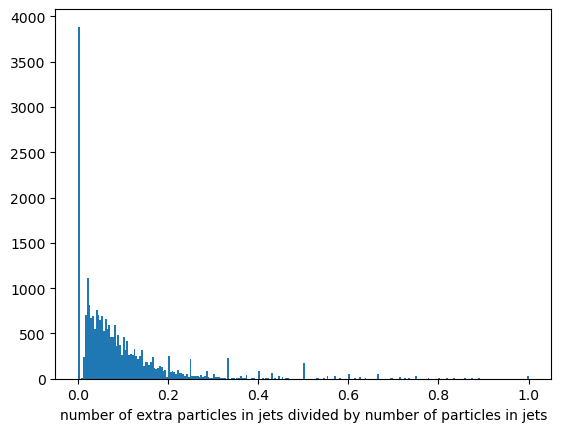

In [19]:
ifig=1;plt.close(ifig);plt.figure(ifig)

nbins = 250
mini = 0 
maxi = 300

num = plt.hist((ak.num(jet_con_in_higgs)-ak.num(ak.local_index(jet_con_in_higgs)[jet_con_in_higgs]))/ak.num(jet_con_in_higgs),
         bins=nbins,
#          density=True
        )

plt.xlabel('number of extra particles in jets divided by number of particles in jets')

Text(0.5, 0, 'momentum of extra particles [GeV]')

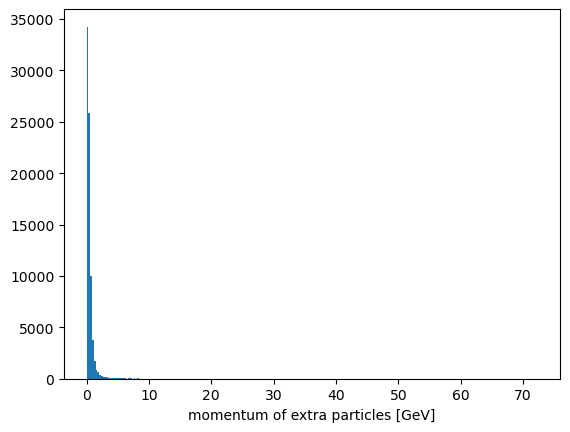

In [20]:
ifig=2;plt.close(ifig);plt.figure(ifig)

nbins = 250
mini = 0 
maxi = 300

plt.hist(ak.flatten(events.PandoraPFOs[muonsevent].p.compute()[total_mask][ak.flatten(pfo_index,axis=2)][jet_con_in_higgs != True]),
         bins=nbins,
        )


plt.xlabel('momentum of extra particles [GeV]')

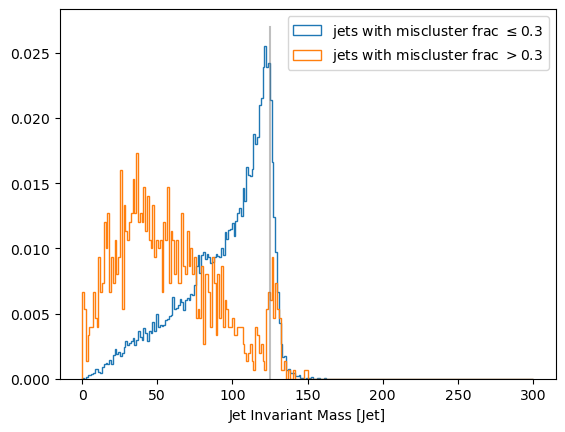

In [35]:
frac_extra = (ak.num(jet_con_in_higgs)-ak.num(ak.local_index(jet_con_in_higgs)[jet_con_in_higgs]))/ak.num(jet_con_in_higgs)

nbins = 250
mini = 0 
maxi = 300

tol = 0.3

# fig,axs = plt.subplots(1,2)
plt.close(1);plt.figure(1)
plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass[frac_extra<=tol]),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
#          linewidth=1.5,
         density = True,
         label=f'jets with miscluster frac $\leq {tol}$')

plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass[frac_extra>tol]),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
#          linewidth=1.5,
         density = True,
         label=f'jets with miscluster frac $> {tol}$')

plt.plot([125,125],[0,0.027],'grey',alpha=0.5)

plt.xlabel('Jet Invariant Mass [Jet]')

plt.legend()

### Source for branching ratios
https://twiki.cern.ch/twiki/bin/view/LHCPhysics/CERNYellowReportPageBR \
https://pdg.lbl.gov/2018/listings/rpp2018-list-z-boson.pdf

## Higgs -> bb exclusively


Need to check if in events with bb, they definitely come from higgs. I'll just make a better mask at the top here later.

In [37]:
mcpdgids = events.MCParticlesSkimmed.pdgId.compute()

In [38]:
pfos = events.PandoraPFOs.compute()

In [39]:
hdecaymask = ak.flatten(higgs_daughter_tree_arr[ak.local_index(ak.num(higgs_daughter_tree_arr,axis=2)) == 1],axis=1)

bmask = ak.all((mcpdgids[hdecaymask] == 5) | (mcpdgids[hdecaymask] == -5),axis=1)

In [40]:
allbmask = ak.fill_none(ak.firsts(ak.local_index(mcpdgids)[mcpdgids == 5]) != None,False)

bpfos = pfos[bmask]

In [41]:
mupair = ak.combinations(bpfos[abs(bpfos.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = ak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)

pfopair = ak.argcombinations(bpfos, 2, fields=["p1", "p2"])

invmass = (bpfos[pfopair.p1][(abs(bpfos[pfopair.p1].pdgId) == 13) & (abs(bpfos[pfopair.p2].pdgId) == 13)] + bpfos[pfopair.p2][(abs(bpfos[pfopair.p1].pdgId) == 13) & (abs(bpfos[pfopair.p2].pdgId) == 13)]).mass

inds = ak.singletons(ak.argmin(abs(invmass - 91.2), axis=1))

# this could be a lot cleaner
mu1ind = pfopair.p1[(abs(bpfos[pfopair.p1].pdgId) == 13) & (abs(bpfos[pfopair.p2].pdgId) == 13)][inds]
mu2ind = pfopair.p2[(abs(bpfos[pfopair.p1].pdgId) == 13) & (abs(bpfos[pfopair.p2].pdgId) == 13)][inds]

In [42]:
m1 = mu1ind[muonsevent]
m2 = mu2ind[muonsevent]

p = bpfos[muonsevent]

In [11]:
%%time
x = []
y = []
z = []
E = []

local_inds = ak.local_index(p)
total_mask = (ak_equals(local_inds, m1)) | (ak_equals(local_inds, m2))

for n in range(len(p)):
    x.append(np.array(p.x[n][total_mask[n]]))
    y.append(np.array(p.y[n][total_mask[n]]))
    z.append(np.array(p.z[n][total_mask[n]]))
    E.append(np.array(p.E[n][total_mask[n]]))

x = ak.Array(x)
y = ak.Array(y)
z = ak.Array(z)
E = ak.Array(E)

# time 56.3 s

CPU times: user 52.6 s, sys: 638 ms, total: 53.2 s
Wall time: 56.3 s


In [44]:
select_pfos = ak.zip(
    {
        'px': x,
        'py': y,
        'pz': z,
        'E': E,
    },
    with_name="LorentzVector",
)

In [45]:
select_clst = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)


jets = ak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

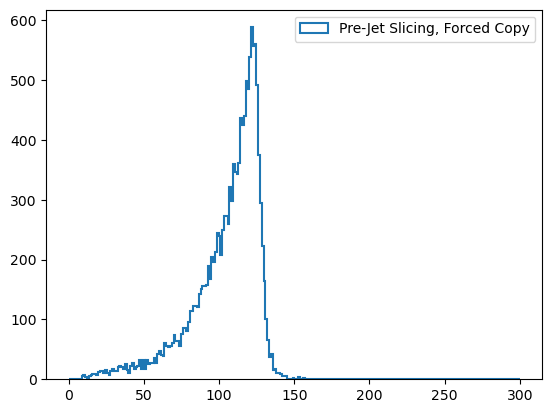

In [46]:
jetpair = ak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs

nbins = 250
mini = 0 
maxi = 300

plt.close(1);plt.figure(1)
plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=1.5,
         label='Pre-Jet Slicing, Forced Copy')


# hist_clusters_2 = (
#     hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Invariant Mass [GeV]") 
#     .Double()
#     .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
# )

# hist_clusters_2.compute().plot1d(label='Pre-Jet Slicing, Masking')
# dak.necessary_columns(hist_clusters_2)

plt.legend()

In [47]:
pfo_index = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=2)

Function that gives the option of how you would like jet constituents to be counted

In [48]:
def jet_truehiggs(reco_particles,mc_particles,true_higgs,reco_mc_index,jet_constits_index,condition='pR',pcrit=(50,5)):
    '''
    compares jet constituents to true higgs products 
    
    Parameters:
    ----------
    reco_particles :: array
        array with all the reco particles
    
    mc_particles :: array
        array with all the mc particles
    
    true_higgs :: array 
        array containing the mc indices of all the children of the higgs in each event 
    
    reco_mc_index :: array 
        array containing a list of mc indices for each reco index
    
    jet_constits_index :: array 
        indices of the pfos contained in the jets in the reco particle array
    
    condition :: str (optional)
        'pR' - the link with the closest momentum match is from the true higgs, to within 50% of the reco momentum 
               or 5 GeV, otherwise the closest \Delta R between the two closest momentum matches
               (criteria can be changed with pcrit)
        'p' - the link with the closest momentum match is from the true higgs
        'any' - any of one of the links from reco particles to mc particles is from the true higgs 
        'all' - all of the links from reco particles to mc particles is from the true higgs 
    
    pcrit :: tuple (optional)
        tuple defining the criteria for using momentum when condition = 'pR' as 
        (percent,absolute) FINISH DESCRIPTION
        
    Returns:
    -------
    
    '''
    # throw error if any of the things are not the right lengths
    if not (len(reco_particles) == len(mc_particles) and len(mc_particles) == len(true_higgs) and len(true_higgs) == len(reco_mc_index) and len(reco_mc_index) == len(jet_constits_index)):
        raise ValueError('first 5 arrays must have the same number of events')
    
    jet_mcindices = reco_mc_index[jet_constits_index]
    jet_con_in_higgs = []
    
    if condition == 'pR':
        # complete (right now this is the same as 'p')
        matched_gen = ak.unflatten(mc_particles[ak.flatten(reco_mc_index,axis=2)],ak.flatten(ak.num(reco_mc_index,axis=2)),axis=1)
        
        mc_reco_cartesian = ak.argcartesian({'mc':matched_gen.p,'reco':ak.singletons(reco_particles.p,axis=1)},axis=2)
        mc_p_argmin = ak.singletons(ak.argmin(abs(matched_gen.p[mc_reco_cartesian['mc']] - ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']]),axis=2),axis=1)
        
        all_jet_inds = ak.flatten(reco_mc_index[mc_p_argmin],axis=2)[jet_constits_index]
        
        for n in range(len(all_jet_inds)):
            jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

        jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
    elif condition == 'any' or condition == 'all':
        all_jet_inds = ak.flatten(jet_mcindices,axis=2)
        
        jet_con_in_higgs = []

        for n in range(len(all_jet_inds)):
            jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

        jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
        if condition == 'any':
            jet_con_in_higgs = ak.any(ak.unflatten(jet_con_in_higgs,ak.flatten(ak.num(jet_mcindices,axis=2)),axis=1),axis=2)
        else:
            jet_con_in_higgs = ak.all(ak.unflatten(jet_con_in_higgs,ak.flatten(ak.num(jet_mcindices,axis=2)),axis=1),axis=2)
        
    elif condition == 'p':
        matched_gen = ak.unflatten(mc_particles[ak.flatten(reco_mc_index,axis=2)],ak.flatten(ak.num(reco_mc_index,axis=2)),axis=1)
        
        mc_reco_cartesian = ak.argcartesian({'mc':matched_gen.p,'reco':ak.singletons(reco_particles.p,axis=1)},axis=2)
        mc_p_argmin = ak.singletons(ak.argmin(abs(matched_gen.p[mc_reco_cartesian['mc']] - ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']]),axis=2),axis=1)
        
        all_jet_inds = ak.flatten(reco_mc_index[mc_p_argmin],axis=2)[jet_constits_index]
        
        for n in range(len(all_jet_inds)):
            jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

        jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
    else:
        raise ValueError('condition must be \'p\', \'any\', or \'all\'')
    
    
    return jet_con_in_higgs

In [49]:
%%time
all_jet_inds = ak.flatten(reco_mc_index[mc_p_argmin],axis=2)[jet_constits_index]
jet_con_in_higgs2 = ak_tools.ak_equals(all_jet_inds,true_higgs)

NameError: name 'reco_mc_index' is not defined

In [50]:
# boolean mask for all the ones that meet momentum criteria for 'pR'
# tomorrow need to make the delta r array too and then find a way to "put them together" using this mask 
reco_particles=bpfos[muonsevent][total_mask]
mc_particles=mc[bmask][muonsevent]
true_higgs=higgs_children[bmask][muonsevent]
reco_mc_index=proper_indices[bmask][muonsevent][total_mask]
jet_constits_index=ak.flatten(pfo_index,axis=2)
pcrit = (50,5)


matched_gen = ak.unflatten(mc_particles[ak.flatten(reco_mc_index,axis=2)],ak.flatten(ak.num(reco_mc_index,axis=2)),axis=1)
        
mc_reco_cartesian = ak.argcartesian({'mc':matched_gen.p,'reco':ak.singletons(reco_particles.p,axis=1)},axis=2)
mc_p_diff = ak.singletons(ak.min(abs(matched_gen.p[mc_reco_cartesian['mc']] - ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']]),axis=2),axis=1)
mc_p_argmin = ak.singletons(ak.argmin(abs(matched_gen.p[mc_reco_cartesian['mc']] - ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']]),axis=2),axis=1)

mc_R_argmin = ak.singletons(ak.argmin(abs(matched_gen.p[mc_reco_cartesian['mc']].metric_table(ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']])),axis=2),axis=1)



# (mc_p_diff < ak.singletons(reco_particles.p,axis=1)*pcrit[0]/100) | (abs(mc_p_diff - ak.singletons(reco_particles.p,axis=1)/2) < pcrit[1])


# this seems off 
# not sure why it's making another dimension
ak.flatten(matched_gen[mc_reco_cartesian['mc']],axis=2).metric_table(ak.flatten(ak.singletons(reco_particles,axis=1)[mc_reco_cartesian['reco']],axis=2))



AttributeError: no field named 'metric_table'

In [51]:
pfos = events.PandoraPFOs.compute()
mc = events.MCParticlesSkimmed.compute()

In [52]:
jet_con_in_higgs_p = jet_truehiggs(bpfos[muonsevent][total_mask],mc[bmask][muonsevent],higgs_children[bmask][muonsevent],proper_indices[bmask][muonsevent][total_mask],ak.flatten(pfo_index,axis=2),'p')
# jet_con_in_higgs_pR = jet_truehiggs(bpfos[muonsevent][total_mask],mc[bmask][muonsevent],higgs_children[bmask][muonsevent],proper_indices[bmask][muonsevent][total_mask],ak.flatten(pfo_index,axis=2),'pR')
jet_con_in_higgs_any = jet_truehiggs(bpfos[muonsevent][total_mask],mc[bmask][muonsevent],higgs_children[bmask][muonsevent],proper_indices[bmask][muonsevent][total_mask],ak.flatten(pfo_index,axis=2),'any')
jet_con_in_higgs_all = jet_truehiggs(bpfos[muonsevent][total_mask],mc[bmask][muonsevent],higgs_children[bmask][muonsevent],proper_indices[bmask][muonsevent][total_mask],ak.flatten(pfo_index,axis=2),'all')

Text(0.5, 0.01, 'Fraction of PFOs in jets linked to no MC particle from higgs')

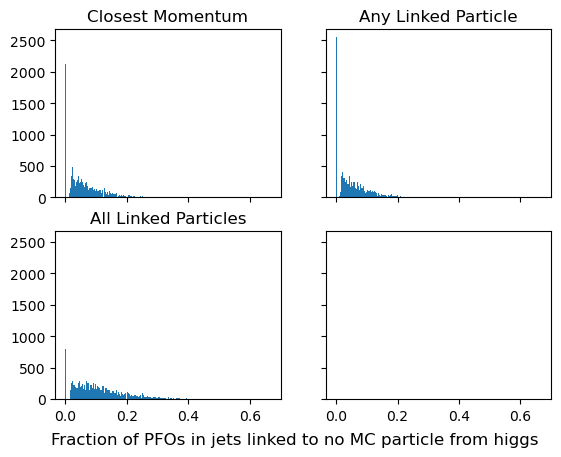

In [53]:
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
axs = ax.flatten()

nbins = 250
mini = 0 
maxi = 300

axs[0].hist((ak.num(jet_con_in_higgs_p)-ak.num(ak.local_index(jet_con_in_higgs_p)[jet_con_in_higgs_p]))/ak.num(jet_con_in_higgs_p),
         bins=nbins,
        )
axs[1].hist((ak.num(jet_con_in_higgs_any)-ak.num(ak.local_index(jet_con_in_higgs_any)[jet_con_in_higgs_any]))/ak.num(jet_con_in_higgs_any),
         bins=nbins,
        )
axs[2].hist((ak.num(jet_con_in_higgs_all)-ak.num(ak.local_index(jet_con_in_higgs_all)[jet_con_in_higgs_all]))/ak.num(jet_con_in_higgs_all),
         bins=nbins,
        )

axs[0].set_title('Closest Momentum')
axs[1].set_title('Any Linked Particle')
axs[2].set_title('All Linked Particles')

fig.supxlabel('Fraction of PFOs in jets linked to no MC particle from higgs')

# plt.tight_layout()

Text(0.5, 0, 'Fraction of particles that do not meet momentum criteria')

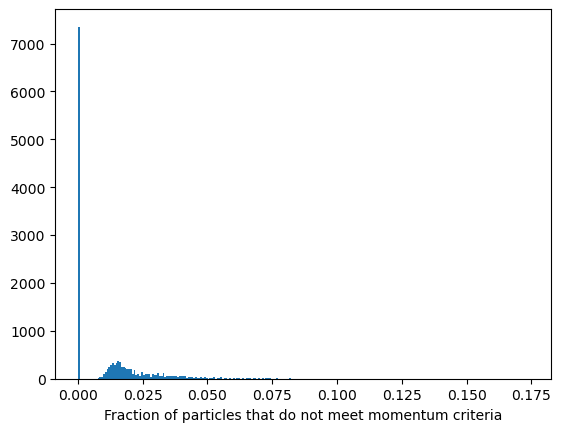

In [54]:
fig,ax = plt.subplots(1,1)

nbins = 250
mini = 0 
maxi = 300

test = ak.flatten((mc_p_diff < ak.singletons(reco_particles.p,axis=1)*0.5) | (abs(mc_p_diff - ak.singletons(reco_particles.p,axis=1)/2) < 5),axis=2)


ax.hist((ak.num(test)-ak.num(ak.local_index(test)[test]))/ak.num(test),
         bins=nbins,
        )

plt.xlabel('Fraction of particles that do not meet momentum criteria')

Text(0.5, 0, 'Momentum of PFOs in jets linked to no MC particle from higgs [GeV]')

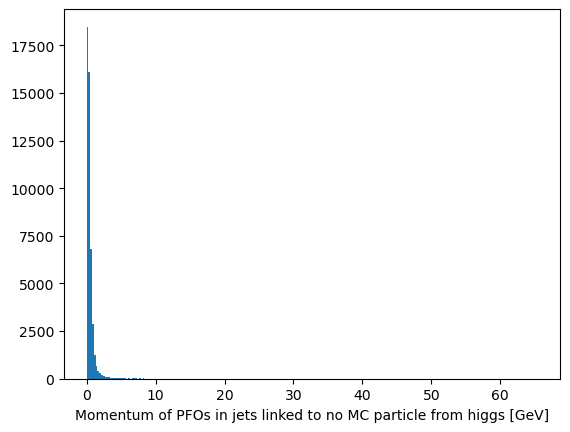

In [55]:
ifig=2;plt.close(ifig);plt.figure(ifig)

nbins = 250
mini = 0 
maxi = 300

plt.hist(ak.flatten(bpfos[muonsevent].p[total_mask][ak.flatten(pfo_index,axis=2)][jet_con_in_higgs_p != True]),
         bins=nbins,
        )


plt.xlabel('Momentum of PFOs in jets linked to no MC particle from higgs [GeV]')

### Higgs peak plots with different levels of allowed 

In [58]:
crit_type = 'p'

jet_con_in_higgs = jet_truehiggs(bpfos[muonsevent][total_mask],mc[bmask][muonsevent],higgs_children[bmask][muonsevent],proper_indices[bmask][muonsevent][total_mask],ak.flatten(pfo_index,axis=2),crit_type)

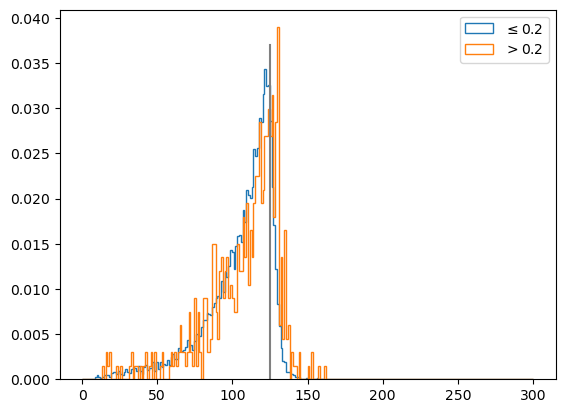

In [62]:
frac_extra = (ak.num(jet_con_in_higgs)-ak.num(ak.local_index(jet_con_in_higgs)[jet_con_in_higgs]))/ak.num(jet_con_in_higgs)

nbins = 250
mini = 0 
maxi = 300

tol = 0.2

# fig,axs = plt.subplots(1,2)
plt.close(1);plt.figure(1)
plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass[frac_extra<=tol]),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
#          linewidth=1.5,
         density = True,
         label=f'$\leq {tol}$')

plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass[frac_extra>tol]),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
#          linewidth=1.5,
         density = True,
         label=f'$> {tol}$')

plt.plot([125,125],[0,0.037],'grey',alpha=1)

plt.legend()